# Extract emebddings, PCA

May need to restart kernel for each dataset if worker error

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import pandas as pd 

# import my_custom_dataset_eval from 
import sys
sys.path.append('/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/evaluation/')
from my_custom_dataset_eval import CTDataset_test

In [2]:
starting_weights = "/home/ben/reef-audio-representation-learning/scratch/baseline/checkpoint-5100.pth.tar"

cfg = {'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_french_polynesia',#######################
       'num_classes': 2, #####################
       'num_workers':4} 

# Load model

In [3]:
# Load model

# Your model definition
class SimClrPytorchResNet50(nn.Module):
    def __init__(self, num_classes):
        super(SimClrPytorchResNet50, self).__init__()
        self.convnet = models.resnet50(pretrained=False)
        last_layer = self.convnet.fc
        in_features = last_layer.in_features
        self.convnet.fc = nn.Identity()
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        '''
            Forward pass. Here, we define how to apply our model. It's basically
            applying our modified ResNet-18 on the input tensor ("x") and then
            apply the final classifier layer on the ResNet-18 output to get our
            num_classes prediction.
        '''
        # x.size(): [B x 3 x W x H]
        features = self.convnet(x)    # features.size(): [B x 512 x W x H]
        prediction = self.classifier(features)  # prediction.size(): [B x num_classes]

        return prediction

# Your function to load pretrained weights
def load_pretrained_weights(cfg, model):
    custom_weights = cfg['starting_weights']
    state = torch.load(open(custom_weights, 'rb'), map_location='cpu')

    if 'state_dict' in state.keys():
        pretrained_dict = state['state_dict']
    else:
        pretrained_dict = state['model']

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k not in ['classifier.weight', 'classifier.bias']}
    log = model.load_state_dict(pretrained_dict, strict=False)
    assert log.missing_keys == ['classifier.weight', 'classifier.bias']
    return model

In [4]:
# Initialize your model
model_instance = SimClrPytorchResNet50(cfg['num_classes'])

# Load the pretrained weights
model_instance = load_pretrained_weights(cfg, model_instance)

/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Dataloader

In [5]:
split = 'test_data'
transform = False
train_percent = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def get_dataloader(cfg, split, transform, train_percent, batch_size, shuffle, num_workers):
    
    dataset = CTDataset_test(cfg, split, transform, train_percent)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return dataloader

sample_loader = get_dataloader(cfg, split, transform=False, train_percent = train_percent, batch_size=64, shuffle=False, num_workers=cfg['num_workers']) 


Does the below cell error? May need to restart kernel

In [7]:
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    model.to(device) #move to gpu
    all_embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (audio, classes) in enumerate(dataloader):
            audio = audio.to(device) #move to gpu
            embeddings = model.convnet(audio)  # Get embeddings from the convnet
            all_embeddings.extend(embeddings.cpu().numpy())
            labels.extend(classes.cpu().numpy())
            
    return all_embeddings, labels

embeddings, labels = extract_multiple_embeddings(model_instance, sample_loader, device)

# Save the embeddings

In [8]:
import pandas as pd

# Assuming embeddings is your list of lists, each of 2048 features
# And labels is your list of labels

# Create a DataFrame
df = pd.DataFrame(embeddings, columns=[f'Feature_{i+1}' for i in range(2048)])

# Insert labels as the first column
df.insert(0, 'Label', labels)

# Save the DataFrame to CSV
df.to_csv('raw_embeddings/' + 'ReefCLR-' + cfg['test_dataset'][5:] + '-embeddings.csv', index=False)

In [9]:
df.head()

,Label,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_2039,Feature_2040,Feature_2041,Feature_2042,Feature_2043,Feature_2044,Feature_2045,Feature_2046,Feature_2047,Feature_2048
0,1,0.917128,0.514379,0.442618,0.853922,0.383245,0.867283,0.686069,0.903708,1.006485,...,0.557613,0.540595,0.488916,0.630372,0.390561,0.533577,0.718749,0.579761,0.824050,0.572824
1,1,0.917583,0.512943,0.444367,0.852815,0.385335,0.867329,0.683194,0.906614,1.007157,...,0.558583,0.540601,0.487653,0.631844,0.391346,0.535359,0.721025,0.577411,0.826399,0.575651
2,1,0.815464,0.719302,0.601633,0.745028,0.446869,0.916246,0.916771,0.539446,0.727328,...,0.458255,0.398599,0.539951,0.957240,0.360331,0.928205,0.743379,0.537051,0.526118,0.440947
3,0,0.816463,0.716947,0.601764,0.746527,0.447060,0.916437,0.912708,0.538276,0.727366,...,0.457184,0.398924,0.538942,0.958116,0.360718,0.929999,0.743010,0.537223,0.523100,0.439797
4,1,0.815399,0.718337,0.603470,0.744375,0.447375,0.915905,0.915381,0.540694,0.727376,...,0.457575,0.398855,0.539441,0.959134,0.358519,0.926882,0.745229,0.537306,0.527225,0.440862


# PCA plot

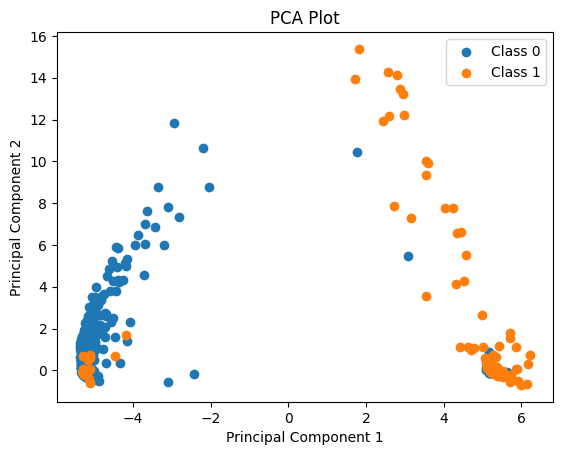

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings to a NumPy array for easier manipulation
embeddings = np.array(embeddings)

# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)

# Fit and transform the embeddings to get new 2D representations
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
classes = np.unique(labels)  # Extract unique labels to identify distinct classes
for class_label in classes:
    idx = np.where(np.array(labels) == class_label)  # Get index where class label is found
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], label=f"Class {class_label}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("PCA Plot")
plt.show()